# ColQwen2: One model for your whole RAG pipeline with adapter hot-swapping 🔥

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/run_e2e_rag_colqwen2_with_adapter_hot_swapping.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

## Introduction

With our new model [*ColQwen2*](https://x.com/ManuelFaysse/status/1839657285053788483), we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from [Qwen2-VL](https://doi.org/10.48550/arXiv.2409.12191) to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.

Using ColQwen2 removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document.

Because ColQwen2 was trained with [LoRA](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora), you can easily use adapter hot-swapping to switch between:
1. Using the pre-trained adapter for creating the document embeddings used for retrieval
2. Unload the adapter and use the backbone VLM for image-grounded generation.

![E2E RAG example](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/rag/e2e_rag_with_colqwen2_diagram.jpeg?raw=true)

With this method, you can use a single model for your whole RAG pipeline, hence saving the need of having multiple models that take up a lot of VRAM! 😍

## Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on HP Omen 16).

## Important ⚠️
The Qwen2-VL model used in ColQwen2 is the [`Qwen/Qwen2-VL-2B-Instruct`](https://huggingface.co/Qwen/Qwen2-VL-2B-Instruct) checkpoint, which is relatively small compared to other VLMs available at the time of writing. Based on my experiments and findings from the [Qwen2-VL paper](https://doi.org/10.48550/arXiv.2409.12191), the 2B version performs well for text-heavy documents (e.g., DocVQA) but falls short compared to larger checkpoints when it comes to understanding complex charts (e.g., ChartQA and InfoVQA).

| Benchmark   | Qwen2-VL-72B | Qwen2-VL-7B | Qwen2-VL-2B (used in ColQwen2) |
|-------------|--------------|-------------|--------------------------------|
| DocVQA      | **96.5**     | 94.5        | 90.1                           |
| ChartQA     | **88.3**     | 83.0        | 73.5                           |
| InfoVQA     | **84.5**     | 76.5        | 65.5                           |

Thus, if you need stronger reasoning capabilities for your RAG, I recommend using using ColQwen2 for retrieval and a larger VLM for generation, e.g. [`Qwen/Qwen2-VL-72B-Instruct`](https://huggingface.co/Qwen/Qwen2-VL-72B-Instruct) or [`mistralai/Pixtral-12B-2409`](https://huggingface.co/mistralai/Pixtral-12B-2409). While this approach uses more VRAM, separate models offer more flexibility for the generation part.

## Imports

This notebook leverages [`colpali-engine`](https://github.com/illuin-tech/colpali), the official implementation of ColPali and ColQwen2. This package also contains the training code (processor, collator, trainer...) for fine-tuning these models on your own dataset.

In [ ]:
!pip install -q -U "colpali-engine>=0.3.1,<0.4.0" requests

In [ ]:
from io import BytesIO
from typing import Any, List, cast

import requests
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from IPython.display import display
from peft import LoraConfig
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

## A few custom utils

In [ ]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    scaled_image = image.resize((new_width, new_height))

    return scaled_image

## The `ColQwen2ForRAG` class

To simplify the usage of ColQwen2 for RAG, I have provided a `ColQwen2ForRAG` class that:
- wraps the original `ColQwen2` model
- hides the complexity behind adapter handling (the current version of PEFT is not always straightforward to use)
- provides a simple API to switch between the retrieval and the generation modes.

In [ ]:
class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 model implementation that can be used both for retrieval and generation.
    Allows switching between retrieval and generation modes.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        Forward pass that calls either Qwen2VLForConditionalGeneration.forward for generation
        or ColQwen2.forward for retrieval based on the current mode.
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        Generate text using Qwen2VLForConditionalGeneration.generate.
        """
        if not self.is_generation_enabled:
            raise ValueError(
                "Set the model to generation mode by calling `enable_generation()` before calling `generate()`."
            )
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self.is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        Switch to retrieval mode.
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        Switch to generation mode.
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False

## Load ColQwen2

Click on the following link to open the model card for [`vidore/colqwen2-v1.0`](https://huggingface.co/vidore/colqwen2-v1.0).

In [ ]:
model_name = "vidore/colqwen2-v1.0"
device = get_torch_device("auto")

print(f"Using device: {device}")

# Get the LoRA config from the pretrained retrieval model
lora_config = LoraConfig.from_pretrained(model_name)

# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))

# Load the model with the loaded pre-trained adapter for retrieval
model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

Run the following cell to load the default query and image inputs. If you want to use your own image/query, upload your image in the Google Colab environment, then replace the following variable values with your own.

The images represent your RAG corpus. For simplicity, we will use only 2 images in this example and ask the model to retrieve the most relevant one for the input query.

In [ ]:
pip install PyMuPDF Pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 90.6 MB/s eta 0:00:00


In [ ]:
!pip install pdf2image
!apt-get update && apt-get install -y poppler-utils


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,798 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [79.8 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,747 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,040 kB]
Hit:13 https://ppa.launchp

In [ ]:
import fitz  # PyMuPDF
from PIL import Image
import io

pdf_path = "/content/1629778064_Gov Scheme & Index_compressed.pdf"
images = []

# Open the PDF document
doc = fitz.open(pdf_path)

# Iterate over each page in the document
for page in doc:
    # Get the list of images on the page
    image_list = page.get_images(full=True)

    # Iterate over each image found
    for img_info in image_list:
        xref = img_info[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]

        # Convert the image bytes to a Pillow Image object
        pil_image = Image.open(io.BytesIO(image_bytes))
        images.append(pil_image)

doc.close()

# The 'images' variable is now a list of Image.Image objects
print(f"{len(images)} images were extracted from the PDF.")


210 images were extracted from the PDF.


Successfully converted 9 PDF pages into images.
Page images have been resized.

--- Displaying Converted PDF Pages ---
Page 1 from document:


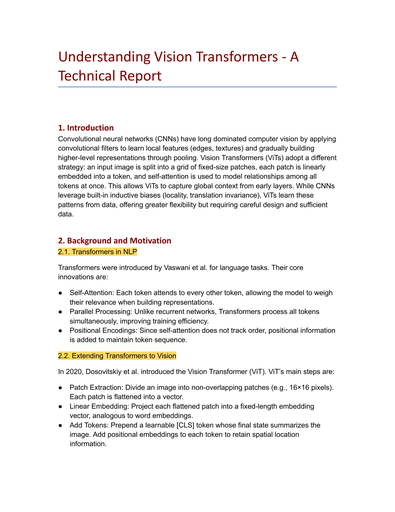

Page 2 from document:


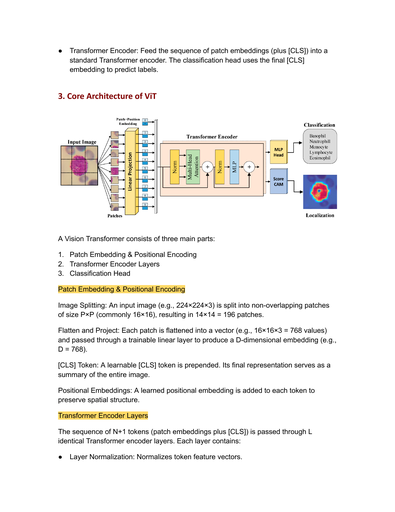

Page 3 from document:


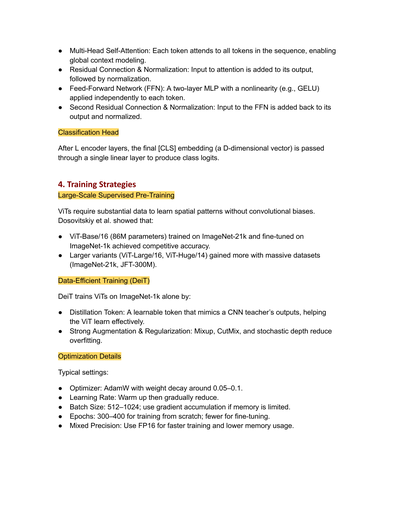

Page 4 from document:


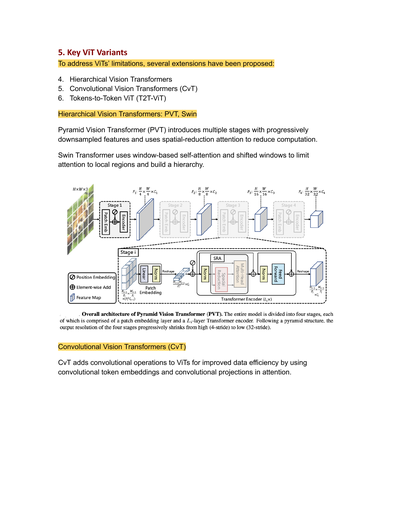

Page 5 from document:


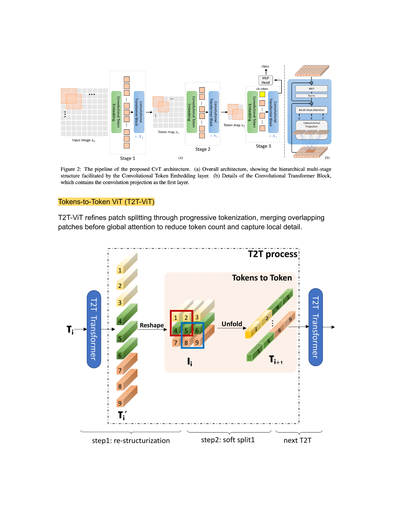

Page 6 from document:


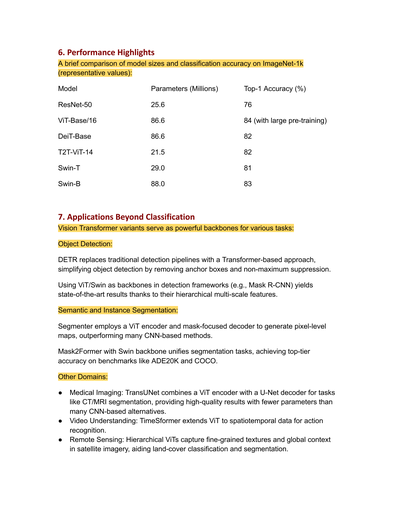

Page 7 from document:


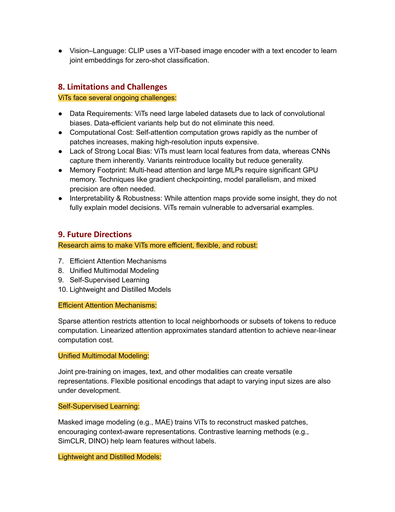

Page 8 from document:


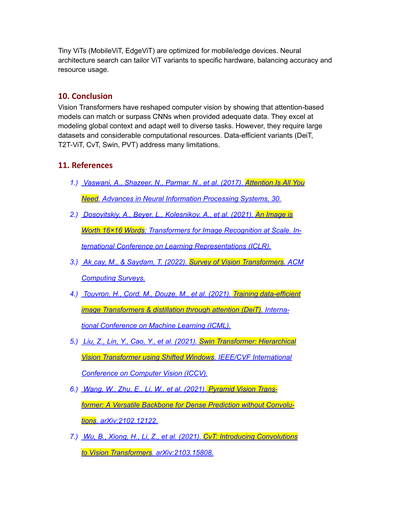

Page 9 from document:


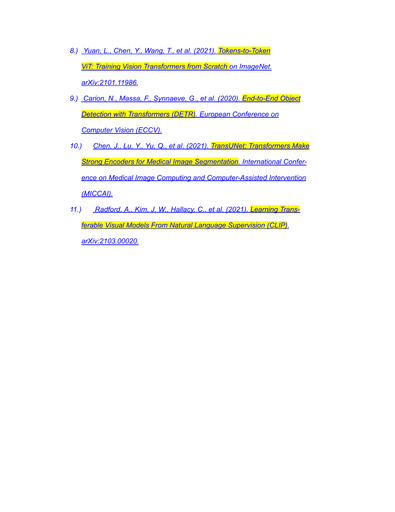

In [ ]:
# ===================================================================
# 1. IMPORTS AND FUNCTION DEFINITIONS
# ===================================================================

# Use pdf2image to convert pages, not just extract images
from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
import io

def scale_image(image: Image.Image, new_height: int) -> Image.Image:
    """
    Resizes a Pillow Image to a new height while maintaining aspect ratio.
    """
    original_width, original_height = image.size
    aspect_ratio = original_width / original_height
    new_width = int(new_height * aspect_ratio)
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return resized_image

# ===================================================================
# 2. DEFINE YOUR INPUTS (QUERY AND DOCUMENT PATH)
# ===================================================================

query = "list all the references"
pdf_path = "/content/ViT_finalReport.pdf"

# ===================================================================
# 3. CONVERT EACH PDF PAGE TO AN IMAGE
# ===================================================================

images = []
try:
    # THIS IS THE KEY CHANGE: Convert each page of the PDF into a PIL Image object
    images = convert_from_path(pdf_path)
    print(f"Successfully converted {len(images)} PDF pages into images.")
except Exception as e:
    print(f"An error occurred: {e}")
    # This error handling is based on the search results [3]
    print("Please ensure 'poppler-utils' is installed and the PDF file path is correct.")

# ===================================================================
# 4. PROCESS AND DISPLAY THE PAGE IMAGES
# ===================================================================

if images:
    # You can still resize the resulting page images for the model
    resized_images = [scale_image(img, new_height=512) for img in images]
    print("Page images have been resized.")

    print("\n--- Displaying Converted PDF Pages ---")
    for i, img in enumerate(resized_images):
        print(f"Page {i+1} from document:")
        # Display the full page image
        display(img)
else:
    print("\nNo pages were converted from the document.")



## Part 1 of RAG: Retrieval

This is the retrieval part of the RAG. In this example, we only keep the top-1 result for demonstration purposes.

In practice, using more results (e.g., top-5) can improve the quality of the final answer.

Processing query...
Processing and scoring 9 images one by one...
  - New best score on image 1: 6.7188
  - New best score on image 2: 6.9688
  - New best score on image 8: 10.8125

Image retrieved for the following query: 'list all the references' with a score of 10.8125


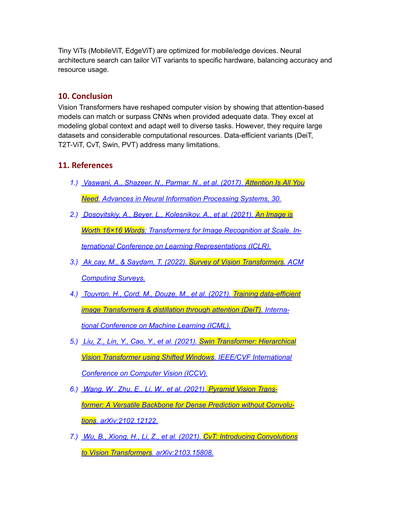

In [ ]:
# ===================================================================
# IMPORTS AND PRELIMINARIES
# ===================================================================
import torch
import os
import gc
from PIL import Image
# (Assuming 'processor_retrieval', 'model', 'images', 'query', etc. are loaded)

# HELPER: Set environment variable to mitigate memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


# ===================================================================
# RETRIEVAL STEP (REVISED TO SCORE INDIVIDUALLY)
# ===================================================================

# Enable retrieval mode on the model
model.enable_retrieval()

# Variables to keep track of the best match
best_score = -1.0
best_image_index = -1
query_embedding = None

# Use torch.no_grad() to save memory
with torch.no_grad():
    # 1. Process the query ONCE and get its embedding
    print("Processing query...")
    batch_queries = processor_retrieval.process_queries([query]).to(model.device)
    query_embedding = model.forward(**batch_queries)

    # 2. Process and SCORE images ONE BY ONE in a loop
    print(f"Processing and scoring {len(images)} images one by one...")
    for i, img in enumerate(images):
        corrected_img = fix_extreme_aspect_ratio(img)
        batch_image = processor_retrieval.process_images([corrected_img]).to(model.device)
        image_embedding = model.forward(**batch_image)

        # 3. SCORE the current image against the query
        current_score = processor_retrieval.score_multi_vector(query_embedding, image_embedding).item()

        # 4. Keep track of the best score and index
        if current_score > best_score:
            best_score = current_score
            best_image_index = i
            print(f"  - New best score on image {i+1}: {best_score:.4f}")

        # 5. Clean up memory immediately
        del corrected_img, batch_image, image_embedding
        torch.cuda.empty_cache()

# 6. Get the top-1 page image using the index of the best score
retrieved_image = images[best_image_index]

print(f"\nImage retrieved for the following query: '{query}' with a score of {best_score:.4f}")
display(scale_image(retrieved_image, new_height=512))

# 7. Final cleanup
del query_embedding
gc.collect()
torch.cuda.empty_cache()


## Part 2 of RAG: Augmented Generation

Now comes the generation part of the RAG. Using the retrieved image from the retrieval part, we will disable the retrieval adapter in ColQwen2 to use its Qwen2-VL VLM backbone to generate the answer based on both the query and the retrieved image.

In [ ]:
# ===================================================================
# PREPARE INPUTS FOR THE GENERATION MODEL
# ===================================================================

# Preprocess the inputs for the generation model
conversation = [
    {
        "role": "user",
        "content": [
            {
                # This placeholder tells the model where the image is.
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]

text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)

# **THE FIX:** Use the 'retrieved_image' variable from the previous step here.
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[retrieved_image], # Use the image you retrieved
    padding=True,
    return_tensors="pt",
).to(model.device)

print("Inputs prepared for generation model.")

# ===================================================================
# GENERATE THE RAG RESPONSE
# ===================================================================

# Generate the RAG response
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# Ensure that only the newly generated token IDs are retained
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)
]

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

# Print the final, context-aware answer
print("\n--- Generated Answer ---")
print(output_text[0])


Inputs prepared for generation model.

--- Generated Answer ---
Here are the references listed in the image:

1. Vaswani, A., Shazeer, N., Parmar, N., et al. (2017). Attention Is All You Need. Advances in Neural Information Processing Systems, 30.
2. Dosovitskiy, A., Beyer, L., Kolesnikov, A., et al. (2021). An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale. International Conference on Learning Representations (ICLR).
3. Akcay, M., & Saydam, T.


If you look closely at the input image, you will see that the model has correctly answered the user query! 🙌🏼

## 🙋🏻 Reminder
If you want to re-run retrieval after this cell, make sure to use `model.enable_retrieval()` before `model.forward(...)`!

## Additional notes

- Try to rerun the previous cells but with the following query instead: `"Which hour of the day had the highest overall electricity generation in 2019?"`. You will see that ColQwen2 is capable of retrieving the correct page, but you should get an hallucinated answer for the generation part. As explained in one of the first sections, this is because [Qwen2-VL-2B](https://huggingface.co/Qwen/Qwen2-VL-2B-Instruct) has only a "small" number of parameters, which limits its chart understanding compared to its larger [12B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) and [72B](https://huggingface.co/Qwen/Qwen2-VL-72B-Instruct) counterparts.
- While our [ColPali](https://huggingface.co/vidore/colpali-v1.3) model was also trained using a LoRA adapter, I do not recommend using it for E2E RAG as the PaliGemma VLM backbone can only take one image input at a time. Consequently, this RAG pipeline will only be capble of using a top-1 page context for generation, which will likely lead to suboptimal results.